In [10]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import pyspark

In [11]:
bank = pd.read_csv("C:/Users/DO PHUONG DUNG/OneDrive - National Economics University/Desktop/cleaned_data.csv")

🔍 Vấn đề đang được giải quyết:
__Một ngân hàng tại Bồ Đào Nha__ đang chuẩn bị tung ra __sản phẩm tiền gửi có kỳ hạn (term deposit)__ và muốn tìm cách __liên hệ đúng người, đúng nhu cầu__. Trong quá khứ, họ đã gọi điện cho hàng loạt khách hàng và có lưu lại kết quả xem ai đã đăng ký sản phẩm sau cuộc gọi, ai thì không.

Tuy nhiên, hiện tại có 2 vấn đề lớn:

__1. Khách hàng than phiền__: Họ bị gọi làm phiền vì những sản phẩm họ không quan tâm → ảnh hưởng hình ảnh ngân hàng.

__2. Không có hệ thống lựa chọn khách hàng tiềm năng__: Hiện tại nhân viên chọn khách hàng một cách thủ công, không hiệu quả.

✅ Mục tiêu dự án:
__Xây dựng một mô hình học máy (machine learning model)__ dựa trên dữ liệu lịch sử, để dự đoán xem __khách hàng nào nên được gọi điện (có khả năng cao sẽ đăng ký tiền gửi kỳ hạn)__ và __khách nào nên bỏ qua__.

Kết quả mong muốn:
– Mô hình sẽ đưa ra dự đoán "yes"/"no" cho từng khách hàng trong dữ liệu test: <br>
→ __"yes"__ nghĩa là __nên gọi, có thể họ sẽ mua sản phẩm__ <br>
→ __"no"__ nghĩa là __không nên gọi, tránh làm phiền__

__Thông tin về khách hàng ngân hàng__

- **`age`**: Tuổi
- **`job`**: Loại công việc
- **`marital`**: Tình trạng hôn nhân  
  *(Lưu ý: `"divorced"` bao gồm cả ly hôn và góa)*
- **`education`**: Trình độ học vấn
- **`default`**: Có từng không trả được khoản vay nào trước đây không?
- **`balance`**: Số dư trung bình hàng năm (euro)
- **`housing`**: Có vay thế chấp không?
- **`loan`**: Có khoản vay tín chấp không?


__Liên quan đến lần liên lạc cuối cùng với khách hàng trong chiến dịch hiện tại__

- **`contact`**: Loại hình liên lạc trong lần cuối cùng
- **`day`**: Ngày của lần liên lạc cuối cùng
- **`month`**: Tháng của lần liên lạc cuối cùng
- **`duration`**: Thời lượng cuộc gọi cuối cùng (tính bằng giây)

---

__Các thuộc tính khác__

- **`campaign`**: Số lần liên hệ trong chiến dịch hiện tại (bao gồm cả lần cuối)
- **`pdays`**: Số ngày kể từ lần cuối được liên hệ trong chiến dịch trước  
  *(Giá trị -1 nghĩa là chưa từng được liên hệ)*
- **`previous`**: Số lần liên hệ trước đây trong các chiến dịch trước đó
- **`poutcome`**: Kết quả của chiến dịch marketing trước

---

__Biến mục tiêu (target)__

- **`y`**: Khách hàng có đăng ký gửi tiết kiệm kỳ hạn hay không?

In [12]:
bank.head(10)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,cellular,5,may,261,1,-1,0,0,no
1,44,technician,single,secondary,no,29,yes,no,cellular,5,may,151,1,-1,0,0,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,cellular,5,may,76,1,-1,0,0,no
3,47,blue-collar,married,secondary,no,1506,yes,no,cellular,5,may,92,1,-1,0,0,no
4,33,blue-collar,single,secondary,no,1,no,no,cellular,5,may,198,1,-1,0,0,no
5,35,management,married,tertiary,no,231,yes,no,cellular,5,may,139,1,-1,0,0,no
6,28,management,single,tertiary,no,447,yes,yes,cellular,5,may,217,1,-1,0,0,no
7,42,entrepreneur,divorced,tertiary,yes,2,yes,no,cellular,5,may,380,1,-1,0,0,no
8,58,retired,married,primary,no,121,yes,no,cellular,5,may,50,1,-1,0,0,no
9,43,technician,single,secondary,no,593,yes,no,cellular,5,may,55,1,-1,0,0,no


#### Feature Engineering

tạo bin cho balance

In [13]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import when, col

# Khởi tạo session nếu chưa có
spark = SparkSession.builder.appName("FeatureBalance").getOrCreate()

# Load data nếu cần
bank = spark.read.csv(r"C:\Users\Ngoc Minh\Downloads\python course\cleaned_data.csv", header=True, inferSchema=True)

# Cast balance nếu cần
bank = bank.withColumn("balance", col("balance").cast("double"))

# Tạo biểu thức phân loại balance
balance_bin_expr = when(col("balance") <= 0, "≤ 0") \
    .when((col("balance") > 0) & (col("balance") <= 500), "0-500") \
    .when((col("balance") > 500) & (col("balance") <= 1500), "500-1500") \
    .when((col("balance") > 1500) & (col("balance") <= 3000), "1500-3000") \
    .when((col("balance") > 3000) & (col("balance") <= 10000), "3000-10000") \
    .otherwise(">10000")

# Thêm cột mới
bank = bank.withColumn("balance_bin", balance_bin_expr)


PySparkRuntimeError: [JAVA_GATEWAY_EXITED] Java gateway process exited before sending its port number.

tạo bin thành age group

In [ ]:
age_group_expr = when(col("age") <= 25, "<25") \
    .when((col("age") > 25) & (col("age") <= 35), "25-35") \
    .when((col("age") > 35) & (col("age") <= 45), "35-45") \
    .when((col("age") > 45) & (col("age") <= 60), "45-60") \
    .otherwise(">60")

bank = bank.withColumn("age_group", age_group_expr)

tạo bin cho biến duration

In [17]:
from pyspark.sql.functions import col, when


In [ ]:
duration_bin_expr = when(col("duration") <= 100, "(0-100]") \
    .when((col("duration") > 100) & (col("duration") <= 200), "(100-200]") \
    .when((col("duration") > 200) & (col("duration") <= 300), "(200-300]") \
    .when((col("duration") > 300) & (col("duration") <= 400), "(300-400]") \
    .when((col("duration") > 400) & (col("duration") <= 500), "(400-500]") \
    .otherwise("(500+)")
    
bank = bank.withColumn("duration_bin", duration_bin_expr)


tạo biến contact history

In [16]:
bank = bank.withColumn(
    "contact_history",
    when(col("previous") == 0, "new").otherwise("contacted_before")
)

AttributeError: 'DataFrame' object has no attribute 'withColumn'

tạo biến financial burnden từ yes (housing) & yes (loan)

In [5]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import when, col

# Khởi tạo SparkSession
spark = SparkSession.builder.appName("FinancialBurdenFeature").getOrCreate()

# Đọc dữ liệu
bank = spark.read.csv(r"C:\Users\Ngoc Minh\Downloads\python course\cleaned_data.csv", header=True, inferSchema=True)

# Tạo cột mới 'financial_burden'
bank = bank.withColumn(
    "financial_burden",
    when((col("housing") == "yes") & (col("loan") == "yes"), "both")
    .when((col("housing") == "yes") | (col("loan") == "yes"), "only one")
    .otherwise("none")
)


ModuleNotFoundError: No module named 'pyspark'

tạo golden group

In [104]:
from pyspark.sql.functions import when, col

# Bước 1: Tính median balance bằng approxQuantile
median_balance = bank.approxQuantile("balance", [0.5], 0.01)[0]

# Bước 2: Gán nhóm 'golden' nếu balance cao & không có khoản vay nào
bank = bank.withColumn(
    "golden_group",
    when((col("balance") > median_balance) & (col("financial_burden") == "none"), "golden")
    .otherwise("other")
)

tạo bin cho pdays

In [105]:
from pyspark.sql.functions import when, col

# Bước 1: Lọc các dòng có pdays ≠ -1
bank = bank.filter(col("pdays") != -1)

# Bước 2: Tạo cột phân loại pdays_range bằng when()
bank = bank.withColumn(
    "pdays_range",
    when((col("pdays") >= 0) & (col("pdays") <= 7), "<1 week")
    .when((col("pdays") > 7) & (col("pdays") <= 14), "1–2 weeks")
    .when((col("pdays") > 14) & (col("pdays") <= 30), "2–4 weeks")
    .when((col("pdays") > 30) & (col("pdays") <= 90), "1–3 months")
    .otherwise(">3 months")
)

In [4]:
bank.show(10)

NameError: name 'bank' is not defined

chuyển dữ liệu về thư viện pandas sau khi feature engineering

In [3]:
bank = bank.toPandas()

NameError: name 'bank' is not defined

bây giờ sẽ dùng pandas và matplotlib để EDA và visualization

#### I. Bức tranh toàn cảnh

__1. Tỷ lệ khách hàng đăng ký sản phẩm (y) là bao nhiêu?__ <br>
 → Tỷ lệ success vs fail để hiểu mức độ "khó" của chiến dịch.

In [2]:
bank['y'].value_counts()

NameError: name 'bank' is not defined

In [15]:
bank['y'].value_counts(normalize=True)*100

y
no     89.63129
yes    10.36871
Name: proportion, dtype: float64

__2. Số lần gọi trong một chiến dịch (campaign) ảnh hưởng thế nào đến quyết định của khách hàng? Có mức gọi tối ưu không?__ <br>

In [ ]:
plt.figure(figsize=(6,4))
sns.boxplot(data=bank, x='y', y='campaign')
plt.title("Campaign Calls by Subscription Status")
plt.xlabel("Subscribed")
plt.ylabel("Number of Calls in Campaign")
plt.show()

#### II. Chân dung khách hàng

__1. Tỷ lệ đăng ký theo nghề nghiệp__ <br>

In [ ]:
# Filter only customers who subscribed
bank_yes = bank[bank['y'] == 'yes']

# Count number of subscribed customers by job
job_counts = bank_yes['job'].value_counts().sort_values(ascending=False)

# Plot the chart
plt.figure(figsize=(10,6))
sns.barplot(x=job_counts.values, y=job_counts.index, palette="Blues_d")
plt.title("Number of Subscribed Customers (y = yes) by Job Group")
plt.xlabel("Number of Subscribed Customers")
plt.ylabel("Job Category")
plt.tight_layout()
plt.show()


- Nhóm quản lý, tiếp theo là kỹ thuật viên và công nhân có tỷ lệ đăng ký cao nhất do có hiểu biết nền tảng về sản phẩm và thị trường, đồng thời có nguồn tài chính ổn định.
- Nhóm nghỉ hưu và sinh viên cũng cho thấy số lượng đăng ký đáng kể, cho thấy sự quan tâm trong các nhóm không đi làm.

=> Khuyến nghị: Tập trung chiến lược tiếp thị vào các nhóm có hiệu suất cao và tìm cách cải thiện chuyển đổi trong các nhóm có hiệu suất kém.

__2. Tỷ lệ đăng kí theo trình độ học vấn__ <br>

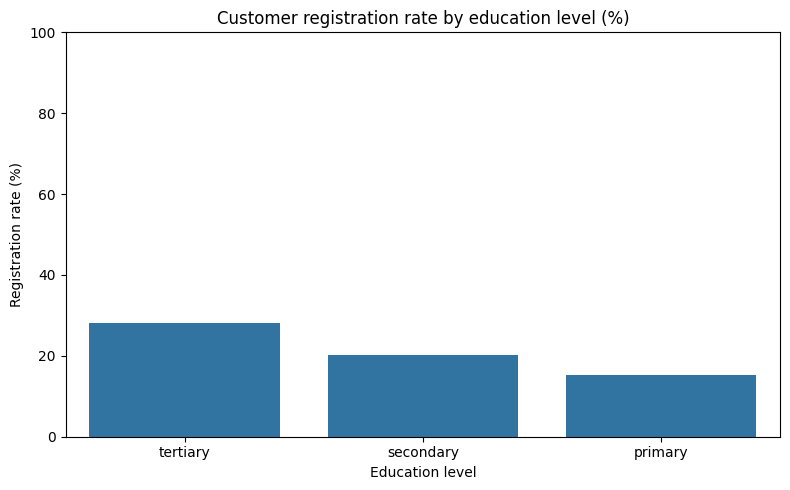

In [114]:
# Tổng số khách hàng theo education level
edu_total = bank['education'].value_counts()

# Số khách hàng đăng ký theo education level
edu_yes = bank[bank['y'] == 'yes']['education'].value_counts()

# Tính tỷ lệ
edu_rate = (edu_yes / edu_total * 100).sort_values(ascending=False)

# Vẽ biểu đồ
plt.figure(figsize=(8,5))
sns.barplot(x=edu_rate.index, y=edu_rate.values)
plt.title("Customer registration rate by education level (%)")
plt.xlabel("Education level")
plt.ylabel("Registration rate (%)")
plt.ylim(0, 100)
plt.tight_layout()
plt.show()

Nhóm có trình độ đại học trở lên có tỷ lệ đăng ký cao nhất trong 3 nhóm do họ có mức độ hiểu biết nhất định đối với thị trường và sản phẩm vì vậy họ dễ tiếp cận với sản phẩm hơn.


#### III. Tài chính cá nhân

__1. Tỷ lệ đăng ký theo số dư tài khoản__ <br>

In [ ]:
# Tính tỷ lệ đăng ký theo nhóm balance_bin
balance_bin_rate = bank.groupby("balance_bin")["y"].value_counts(normalize=True).unstack().fillna(0).reset_index()

# Vẽ biểu đồ tỷ lệ y = yes theo từng bin
plt.figure(figsize=(10,6))
sns.barplot(data=balance_bin_rate, x="balance_bin", y="yes", palette="Blues_d")
plt.title("Subscription Rate by Balance Bin")
plt.xlabel("Balance Bin")
plt.ylabel("Subscription Rate (y = yes)")
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.grid(axis="y")
plt.tight_layout()
plt.show()


import matplotlib.pyplot as plt

# Lọc khách đã đăng ký
bank_yes = bank[bank['y'] == 'yes']

# Đếm số lượng đăng ký theo balance_bin
bin_counts = bank_yes['balance_bin'].value_counts().sort_index()

# Vẽ pie chart
plt.figure(figsize=(8,6))
plt.pie(bin_counts, labels=bin_counts.index, autopct='%1.1f%%', startangle=90, colors=plt.cm.Blues(range(100, 256, int(155/len(bin_counts)))))
plt.title("Distribution of Subscribed Customers by Balance Bin (%)")
plt.axis('equal')  # Bắt buộc để hình tròn đều
plt.tight_layout()
plt.show()

Nhóm có balance cao có tỷ lệ đăng ký cao hơn do họ có một nền tảng tài chính mạnh để mua thêm những sản phẩm tài hcinhs mới. Tuy nhiên, nhóm có balance âm hoặc thấp vẫn đăng ký, cho thấy đây không phải là yếu tố quyết định tới nhu cầu về sản phẩm, tuy nhiên, nên có một kế hoạch tiếp thị và bán sản phẩm phù hợp cho từng nhóm.

__2. Tỷ lệ đăng ký theo tình trạng vay thế chấp__ <br>


In [ ]:
plt.figure(figsize=(6,4))
sns.countplot(data=bank, x="housing", hue="y")
plt.title("Subscription Rate by Housing Loan")
plt.xlabel("Has Housing Loan")
plt.ylabel("Count")
plt.legend(title="Subscribed")
plt.show()

__3. Tỷ lệ đăng ký theo tình trạng vay cá nhân__ <br>


In [ ]:
plt.figure(figsize=(6,4))
sns.countplot(data=bank, x="loan", hue="y")
plt.title("Subscription Rate by Personal Loan")
plt.xlabel("Has Personal Loan")
plt.ylabel("Count")
plt.legend(title="Subscribed")
plt.show()

Những người có khoản vay thế chấp và khoản vay cá nhân có tỷ lệ đăng ký thấp hơn do họ đã có nghĩa vụ tài hcinhs phải trả vì vậy gánh nặng tài chính hiện tại khiến họ ít sẵn sàng để mua thêm sản phẩm mới.

__3. Tỷ lệ đăng ký theo tình trạng vay và số dư__ <br>

In [ ]:
# Bước 1: Tính balance trung bình và tỷ lệ đăng ký theo housing & loan
df_agg = bank.groupby(["housing", "loan"]).agg(
    avg_balance=("balance", "mean"),
    pct_yes=("y", lambda x: (x == "yes").mean() * 100)
).reset_index()

# Bước 2: Pivot để chuẩn bị dữ liệu cho heatmap
heatmap_data = df_agg.pivot(index="housing", columns="loan", values="pct_yes")

# Bước 3: Vẽ heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(heatmap_data, annot=True, fmt=".1f", cmap="Blues")

plt.title("Subscription Rate (%) by Loan and Housing Status")
plt.xlabel("Personal Loan")
plt.ylabel("Housing Loan")
plt.tight_layout()
plt.show()


- Nhóm không có khoản vay thế chấp, khoản vay cá nhân và balance cao là nhóm có khả nnagw mua sản phẩm ao nhất với 17.3% do họ không có gánh nặng tài chính và có đủ tiền để mua thêm những sản phẩm mới.

- Nhóm có hoản vay cá nhân dù có balance cao nhưng cũng không có nhu cầu cao trong việc mua sản phẩm.

- Nhóm có nhu cầu tiếp cận sản phẩm thấp nhất là nhóm có balnce thấp và phải gánh chịu cả hai hoản vay thế chấp và khoản vay cá nhân.

=> ***Chiến lược trọng tâm*** là "low risk, high conversion".

#### IV. Tương tác cuộc gọi. 

__1. Tỷ lệ đăng ký theo số lượng cuộc gọi__ <br>

In [ ]:
# Tính tỷ lệ đăng ký theo số lần gọi
campaign_ratio = bank.groupby('campaign')['y'].value_counts(normalize=True).unstack().fillna(0)
campaign_ratio = campaign_ratio.reset_index()

plt.figure(figsize=(10,5))
sns.lineplot(data=campaign_ratio, x='campaign', y='yes', marker='o')
plt.title("Subscription Rate vs Number of Calls")
plt.xlabel("Number of Calls (campaign)")
plt.ylabel("Proportion Subscribed")
plt.grid(True)
plt.show()

Gọi quá nhiều lần không giúp tăng tỷ lệ đăng ký mà ngược lại có xu hướng làm giảm do khách hàng có thể coi đây là cuộc gọi lừa đảo và tránh việc nghe điện. Điều này cho thấy hiệ ứng spam mang lại hiệu quả khá tiêu cực.

=> Vì vậy ***số lần gọi tối ưu*** là 1-2 lần.

__2. Tỷ lệ đăng ký theo thời lượng cuộc gọi__ <br>

In [ ]:
duration_rate = bank.groupby('duration_bin')['y'].value_counts(normalize=True).unstack().fillna(0)
duration_rate = duration_rate.reset_index()
# Chuyển duration_bin thành chuỗi để vẽ được trục x
duration_rate["duration_bin"] = duration_rate["duration_bin"].astype(str)

# Vẽ lại
plt.figure(figsize=(8,5))
sns.lineplot(data=duration_rate, x="duration_bin", y="yes", marker='o')
plt.title("Subscription Rate by Call Duration Range")
plt.xlabel("Call Duration Range (seconds)")
plt.ylabel("Subscription Rate (y = yes)")
plt.grid(True)
plt.tight_layout()
plt.show()

- Thời lượng gọi càng dài, tỷ lệ đăng ký càng cao cho thấy người mua sản phẩm có hứng thú với sản phẩm và sẵn sàng nghe giới thiệu về sản phẩm.

=> Cần tăng chất lượng cuộc gọi để cung cấp được luongj wthoong tin nhiều nhất về sản phẩm và có khả năng thu hút khách hàng.

__3. Tỷ lệ đăng ký theo kênh liên hệ__ <br>

In [ ]:
# Tính tỷ lệ đăng ký theo job & contact
job_contact = bank.groupby(["job", "contact"])["y"].value_counts(normalize=True).unstack().fillna(0).reset_index()

# Vẽ biểu đồ
plt.figure(figsize=(12,6))
sns.barplot(data=job_contact, x="job", y="yes", hue="contact")
plt.title("Subscription Rate by Contact Channel and Job")
plt.ylabel("Subscription Rate (y = yes)")
plt.xlabel("Job")
plt.xticks(rotation=45)
plt.legend(title="Contact")
plt.tight_layout()
plt.show()


Cellular hiệu quả hơn so với Telephone do việc dùng điện thoại bàn ngày nay đã giảm hẳn. Việc gọi vào cellular phone giúp ngân hàng dễ tiếp cận khách hàng hơn.

#### V. Chiến dịch trước để lại gì?. 

__1. Tỷ lệ đăng ký theo chiến dịch trước__ <br>

In [ ]:
history_rate = bank.groupby("contact_history")["y"].value_counts(normalize=True).unstack().fillna(0).reset_index()
plt.figure(figsize=(6, 4))
sns.barplot(data=history_rate, x="contact_history", y="yes", palette="Blues")
plt.title("Subscription Rate by Previous Contact History")
plt.xlabel("Customer Contact History")
plt.ylabel("Subscription Rate (y = yes)")
plt.ylim(0, 0.3)
plt.grid(axis="y")
plt.tight_layout()
plt.show()


Biểu đồ cho thấy những khách hàng đã từng được liên hệ trong quá khứ có tỷ lệ đăng kí cao hơn so với những chưa từng được liên hệ. Điều này cho thấy việc chăm sóc khách hàng hay cụ thể là telesale có thể mang lại hiệu quả đáng kể, giúp tăng khả năng đăng ký của khách hàng.

__2. Tỷ lệ đăng ký theo thời gian kể từ chiến dịch trước__ <br>

In [ ]:
poutcome_rate = bank.groupby("poutcome")["y"].value_counts(normalize=True).unstack().fillna(0).reset_index()

# Tạo bản sao để không ảnh hưởng gốc
plot_data = poutcome_rate.copy()

# Vẽ biểu đồ
plt.figure(figsize=(6, 4))
sns.barplot(data=plot_data, x="poutcome", y="yes", palette="Greens")

# Đổi nhãn trực tiếp trên trục
plt.xticks(ticks=[0, 1], labels=["Not Successful", "Successful"])

plt.title("Subscription Rate by Previous Campaign Success")
plt.xlabel("Previous Campaign Outcome")
plt.ylabel("Subscription Rate (y = yes)")
plt.ylim(0, 0.8)
plt.grid(axis="y")
plt.tight_layout()
plt.show()



Tỷ lệ khách hàng đã thành công trong chiến dịch trước có tỷ lệ đăng ký rất cao trong lần này do họ đã có sự tin tưởng nhất định vào sản phẩm. Vì vậy đây là nhóm khách hàng rất tiềm năng, nên được ưu tiên trong các chiến dịch mới, càn chú trọng khâu chăm sóc khách hàng để duy trì mối quan hệ và bán thêm sản phẩm.

#### VI. Phân tích cụ thể?. 


__1. Heatmap job education y__ <br>

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Tính tỷ lệ đăng ký theo job + education
pivot_data = bank.groupby(["job", "education"])["y"].value_counts(normalize=True).unstack().fillna(0).reset_index()

# Pivot để tạo heatmap
heatmap_data = pivot_data.pivot(index="job", columns="education", values="yes")

# Vẽ heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".1%", cmap="Greens")
plt.title("Subscription Rate by Job and Education")
plt.xlabel("Education Level")
plt.ylabel("Job")
plt.tight_layout()
plt.show()


Những người với trình độ học vấn cao, có tỷ lệ đăng ký cao hơn so với trình độ primary và secondary.
Những người làm trong các ngành chuyên môn, liên quan nhiều đến lao động trí óc như admin, entrepreneur cũng là nhóm khách hàng nên được chú trọng.
=> Vì họ là những khách hàng hiểu được thị trường và sản phẩm, có tài chính ổn định và dễ tiếp cận




__2. Golden group__ <br>

In [ ]:
# Tính tỷ lệ đăng ký
group_rate = bank.groupby("golden_group")["y"].value_counts(normalize=True).unstack().fillna(0).reset_index()

# Vẽ biểu đồ
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6, 4))
sns.barplot(data=group_rate, x="golden_group", y="yes", palette="Greens")
plt.title("Subscription Rate: Golden Group vs Others")
plt.ylabel("Subscription Rate (y = yes)")
plt.xlabel("Customer Group")
plt.ylim(0, 0.3)
plt.grid(axis="y")
plt.tight_layout()
plt.show()


Đây là nhóm có nguồn tiền dồi dào, không bị ràng buộc tài chính do có nguồn tài chính dồi dào và khả năng đầu tư cao hơn.
Vì là nhóm có tỷ lệ chuyển đổi cao nhất nên cần phải có kế hoạch tiếp cận và ưu tiên tập trung nhóm khách hàng trên.